In [1]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize                                       # flatten json to dataframe
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pytz
import datetime
from simple_salesforce import Salesforce                                        # !pip3 install simple-salesforce 
with open('.sfdc') as f:
    uname, spass, stoken, ppass, ptoken = [x.strip("\n") for x in f.readlines()]
sf = Salesforce(username=uname, password=spass, security_token=stoken)          # authenticate
end = datetime.datetime.now(pytz.UTC)                                           # salesforce API requires UTC
print("@ ", end)

@  2019-12-19 04:36:30.885911+00:00


### pull Leads from Salesforce, flatten to dataframe, tabulate & build map

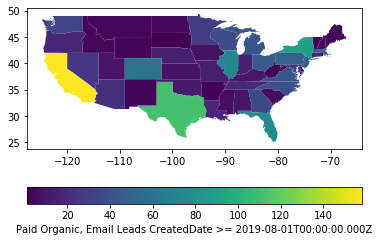

In [2]:
date = "CreatedDate >= 2019-08-01T00:00:00.000Z"
soql = ("SELECT CreatedDate, Source__c, StateCode, Industry_Vertical__c, Company FROM Lead WHERE Source__c  NOT IN('FLAG', 'Event') AND Industry_Vertical__c NOT IN('dupe','test','spam') AND " + date + "")
query = sf.query(soql)                                       
df = json_normalize(query['records'])                                         # flatten json response to dataframe
wdf = df.groupby("StateCode").count()                                         # tab by state
wdf = wdf.drop(['CreatedDate','Source__c', 
                'Industry_Vertical__c', 
                'attributes.type', 
                'attributes.url'], axis=1)                                    # clean unsed columns
geo_df = gpd.read_file("data/maps/states_21basic/states.shp")
geo_df = geo_df.set_index("STATE_ABBR")                                       # drop HI & AK
geo_df = geo_df.drop(['AK','HI','DC'], axis=0)
usmap = geo_df.join(wdf, on="STATE_ABBR")
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
usmap.plot(column='Company',
           ax=ax,
           legend=True,
           legend_kwds={'label': "Paid Organic, Email Leads " + date,
                        'orientation': "horizontal"})
fig.savefig("leadsAUG2019.png", dpi=300)